In [1]:
import numpy as np
import pandas as pd
# 设置显示的最大行
PREVIOUS_MAX_ROWS = pd.options.display.max_rows  
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
# 设置画布尺寸
plt.rc('figure', figsize=(10, 6))
# 设置打印精确度
np.set_printoptions(precision=4, suppress=True)

# 1. `GroupBy`机制


In [2]:
df = pd.DataFrame({'key': list('ABCABCABC'), 
                   'data': [0, 5, 10, 5, 10, 15, 10, 15, 20]})
df

,key,data
0,A,0
1,B,5
2,C,10
3,A,5
4,B,10
5,C,15
6,A,10
7,B,15
8,C,20


In [3]:
# 分组、求和
df.groupby('key').sum()

,data
key,
A,15
B,30
C,45


分组聚合示意图：

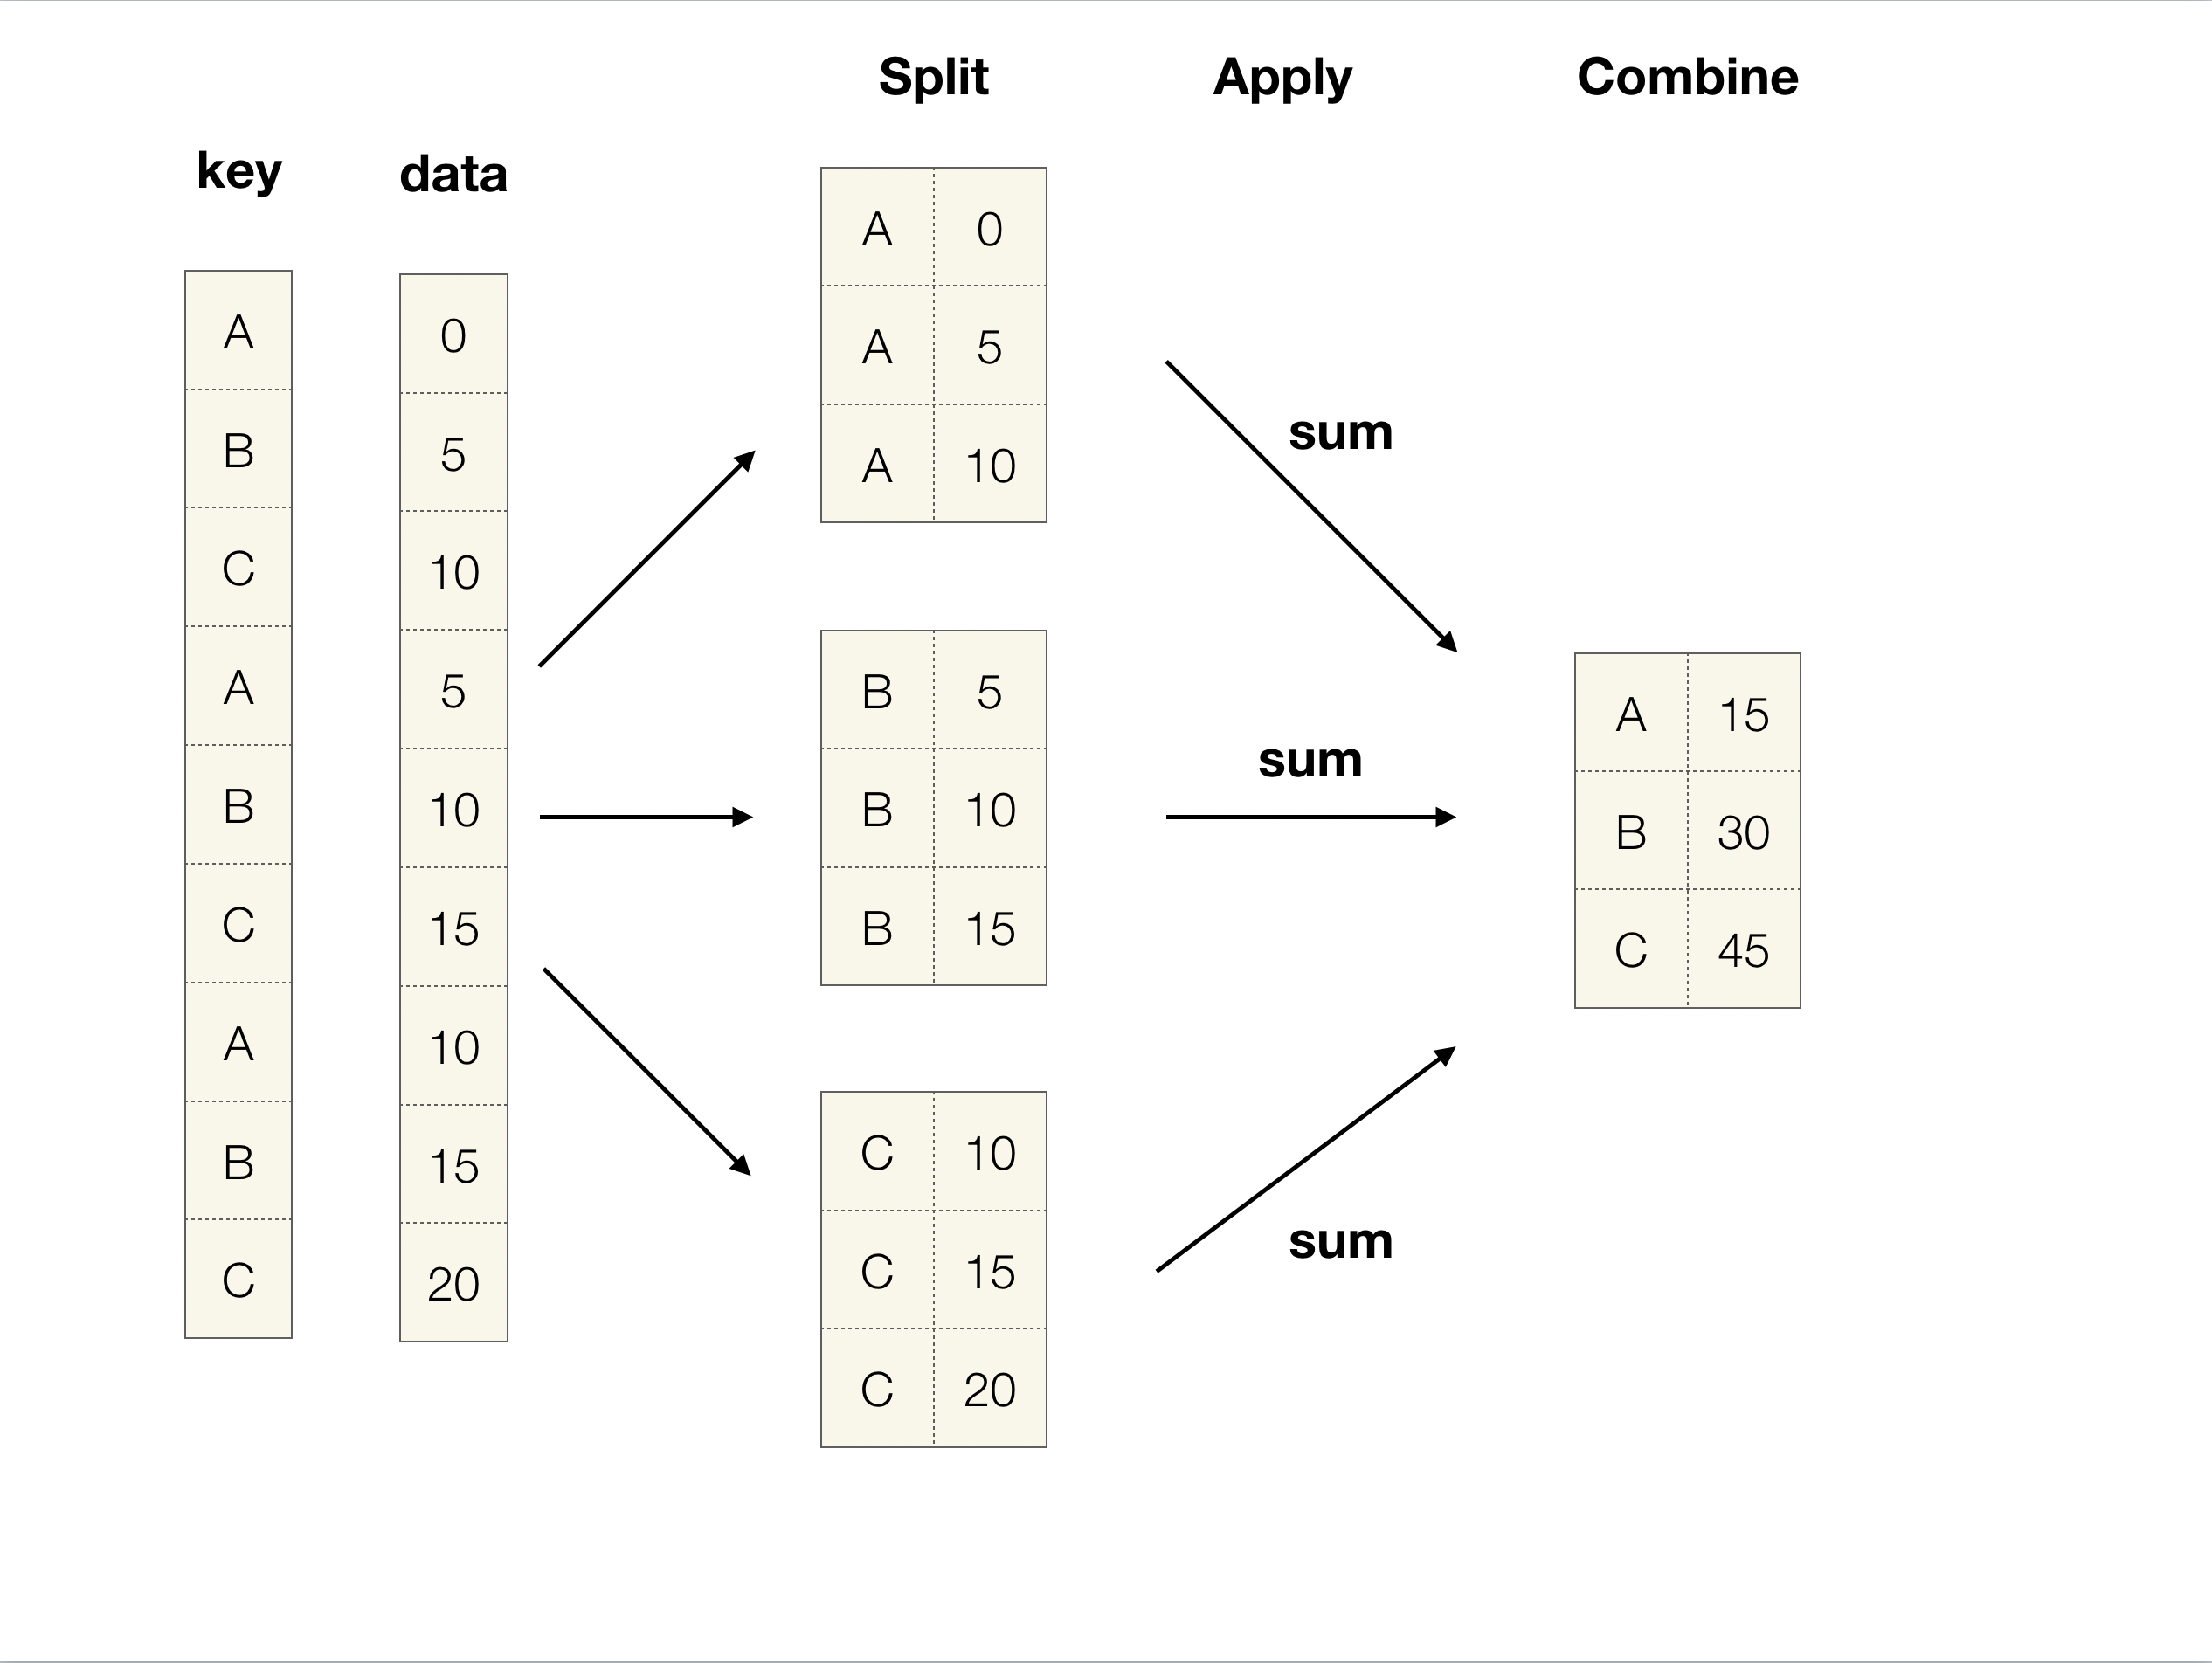

In [4]:
df = pd.DataFrame({'key1': ['a', 'a', 'b', 'b', 'a'], 
                   'key2': ['one', 'two', 'one', 'two', 'one'], 
                   'data1': np.random.randn(5), 
                   'data2': np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [5]:
df['data1']

0   -0.204708
1    0.478943
2   -0.519439
3   -0.555730
4    1.965781
Name: data1, dtype: float64

In [6]:
# 根据key1标签计算data1列均值
grouped = df['data1'].groupby(df['key1'])  
# 返回GroupBy对象
# 除了一些关于分组键df['key1']的一些中间数据外，它实际上还没有进行任何计算
# 拥有所有必须的信息，之后可以在每个分组上应用操作
grouped  

In [7]:
grouped.mean()

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [8]:
# 按照多列进行分组
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

In [9]:
means.unstack()

key2,one,two
key1,,
a,0.880536,0.478943
b,-0.519439,-0.555730


In [10]:
# 分组键也可以是正确长度的任何数组
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.478943
            2006   -0.519439
Ohio        2005   -0.380219
            2006    1.965781
Name: data1, dtype: float64

In [11]:
# DataFrame中可以直接传递列名
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [12]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.880536  1.319920
     two   0.478943  0.092908
b    one  -0.519439  0.281746
     two  -0.555730  0.769023

In [13]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

## 1.1 遍历个分组
`GroupBy`对象支持迭代，会生成一个包含组名和数据块的2位元组序列

In [14]:
for name, group in df.groupby('key1'):
    print(name)
    print('-'*10)
    print(group)
    print('='*10)

a
----------
  key1 key2     data1     data2
0    a  one -0.204708  1.393406
1    a  two  0.478943  0.092908
4    a  one  1.965781  1.246435
b
----------
  key1 key2     data1     data2
2    b  one -0.519439  0.281746
3    b  two -0.555730  0.769023


In [15]:
# 在多分组键的情况下，元组中的第一个元素是键值的元组
for name, group in df.groupby(['key1', 'key2']):
    print(name)
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -0.204708  1.393406
4    a  one  1.965781  1.246435
('a', 'two')
  key1 key2     data1     data2
1    a  two  0.478943  0.092908
('b', 'one')
  key1 key2     data1     data2
2    b  one -0.519439  0.281746
('b', 'two')
  key1 key2    data1     data2
3    b  two -0.55573  0.769023


In [16]:
pieces = dict(list(df.groupby('key1')))
pieces['a']

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
4,a,one,1.965781,1.246435


In [17]:
# groupby可以在axis=1的轴向上分组(默认为axis=0)
print(df.dtypes)
print('='*10)
grouped = df.groupby(df.dtypes, axis=1)
for dtype, group in grouped:
    print(dtype)
    print(group)

key1      object
key2      object
data1    float64
data2    float64
dtype: object
float64
      data1     data2
0 -0.204708  1.393406
1  0.478943  0.092908
2 -0.519439  0.281746
3 -0.555730  0.769023
4  1.965781  1.246435
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


## 1.2 选择一列或所有列的子集

In [18]:
df['data2']

0    1.393406
1    0.092908
2    0.281746
3    0.769023
4    1.246435
Name: data2, dtype: float64

In [19]:
df.groupby(['key1', 'key2'])[['data2']].mean()  # 返回DataFrame

data2
key1 key2          
a    one   1.319920
     two   0.092908
b    one   0.281746
     two   0.769023

In [20]:
s_grouped = df.groupby(['key1', 'key2'])['data2']  # 返回Series
s_grouped
s_grouped.mean()  

key1  key2
a     one     1.319920
      two     0.092908
b     one     0.281746
      two     0.769023
Name: data2, dtype: float64

## 1.3 使用字典和Series分组

In [21]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [22]:
# 用字典表示各列的分组关系
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}
# 根据字典构造传给groupby的数组
by_column = people.groupby(mapping, axis=1)
by_column.sum()

,blue,red
Joe,0.503905,1.063885
Steve,1.297183,-1.553778
Wes,-1.021228,-1.116829
Jim,0.524712,1.770545
Travis,-4.230992,-2.405455


In [23]:
# Series也有相同的功能
map_series = pd.Series(mapping)
print(map_series)
people.groupby(map_series, axis=1).count()

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object


,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


## 1.4 使用函数分组
与使用字典或Series分组相比，使用Python函数是定义分组关系的一种更为通用的方式。作为分组键传递的函数将会按照每个索引值调用一次，同时返回值会被作用分组名称。  
> 对people这个DataFrame，根据名字的长度来进行分组。  
虽然我们可以计算出字符串长度的数组，但直接传递`len`函数更为简单

In [24]:
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [25]:
people.groupby(len).sum()

,a,b,c,d,e
3,0.591569,-0.993608,0.798764,-0.791374,2.119639
5,0.886429,-2.001637,-0.371843,1.669025,-0.438570
6,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [26]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.539741 -1.296221  0.274992 -1.021228 -0.577087
  two  0.124121  0.302614  0.523772  0.000940  1.343810
5 one  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 two -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

## 1.5 根据索引层级分组

In [27]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.560145 -1.265934  0.119827 -1.063512  0.332883
1     -2.359419 -0.199543 -1.541996 -0.970736 -1.307030
2      0.286350  0.377984 -0.753887  0.331286  1.349742
3      0.069877  0.246674 -0.011862  1.004812  1.327195

In [28]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


# 2. 分组数据的计算与聚合(`agg`)

[$$常见计算与描述性统计函数$$](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html)

| 函数名 | 描述 |
| --- | --- |
| `count` | 分组中非NA值数量 |
| `sum` | 非NA值的累和 |
| `mean` | 非NA值的均值 |
| `median` | 非NA值的算术中位数 |
| `std`、`var` | 无偏的（n-1分母）标准差和方差 |
| `min`、`max` | 非NA值的最小值和最大值 |
| `prod` | 非NA值的乘积 |
| `first`、`last` | 非NA值的第一个和最后一个值 |

In [2]:
df = pd.DataFrame({'key1': ['a', 'a', 'b', 'b', 'a'], 
                   'key2': ['one', 'two', 'one', 'two', 'one'], 
                   'data1': np.random.randn(5), 
                   'data2': np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [5]:
grouped['data1']

In [6]:
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

key1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

In [22]:
for name, df in grouped:
    print(name)
#     print(df)
    for col in df.columns:
        try:
            print(peak_to_peak(df[col]))
        except:
            continue

a
2.1704882319874272
1.3004979562292727
b
0.036291589290751936
0.48727641478163625


In [7]:
grouped

In [10]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.746672  1.109736 -0.204708  0.137118  0.478943  1.222362   
b      2.0 -0.537585  0.025662 -0.555730 -0.546657 -0.537585 -0.528512   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     1.965781   3.0  0.910916  0.712217  0.092908  0.669671  1.246435   
b    -0.519439   2.0  0.525384  0.344556  0.281746  0.403565  0.525384   

                          
           75%       max  
key1                      
a     1.319920  1.393406  
b     0.647203  0.769023

In [16]:
# 使用聚合函数，将函数传给aggregate或agg方法
# 聚合函数是将分组后的数据，按列进行计算，再将计算后的数据聚合在一起。
def peak_to_peak(arr):
    '''
    arr: Series
    '''
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.170488,1.300498
b,0.036292,0.487276


## 2.1 逐列及多函数应用

In [23]:
tips = pd.read_csv('../datas/tips.csv')
print(tips)
# 添加一列总账单的小费比例
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips.head()

     total_bill   tip smoker   day    time  size
0         16.99  1.01     No   Sun  Dinner     2
1         10.34  1.66     No   Sun  Dinner     3
2         21.01  3.50     No   Sun  Dinner     3
3         23.68  3.31     No   Sun  Dinner     2
4         24.59  3.61     No   Sun  Dinner     4
..          ...   ...    ...   ...     ...   ...
239       29.03  5.92     No   Sat  Dinner     3
240       27.18  2.00    Yes   Sat  Dinner     2
241       22.67  2.00    Yes   Sat  Dinner     2
242       17.82  1.75     No   Sat  Dinner     2
243       18.78  3.00     No  Thur  Dinner     2

[244 rows x 6 columns]


,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


In [57]:
for name, df in grouped_pct:
    print(name)
    print(df)

('Fri', 'No')
91     0.155625
94     0.142857
99     0.120385
223    0.187735
Name: tip_pct, dtype: float64
('Fri', 'Yes')
90     0.103555
92     0.173913
93     0.263480
95     0.117750
96     0.146628
97     0.124688
98     0.142789
100    0.220264
101    0.195059
220    0.180921
221    0.259314
222    0.223776
224    0.117735
225    0.153657
226    0.198216
Name: tip_pct, dtype: float64
('Sat', 'No')
19     0.162228
20     0.227679
21     0.135535
22     0.141408
23     0.192288
         ...   
233    0.136490
235    0.124131
238    0.130338
239    0.203927
242    0.098204
Name: tip_pct, Length: 45, dtype: float64
('Sat', 'Yes')
56     0.078927
58     0.156584
60     0.158206
61     0.144823
62     0.179673
         ...   
234    0.193175
236    0.079365
237    0.035638
240    0.073584
241    0.088222
Name: tip_pct, Length: 42, dtype: float64
('Sun', 'No')
0      0.059447
1      0.160542
2      0.166587
3      0.139780
4      0.146808
         ...   
163    0.144823
165    0.141925


In [24]:
grouped = tips.groupby(['day', 'smoker'])
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')
# grouped_pct.mean()

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [28]:
for name,ser in grouped_pct:
    print(name)
    print(ser.mean(), ser.std(), peak_to_peak(ser))

('Fri', 'No')
0.151650441509014 0.02812295451594084 0.06734943559063597
('Fri', 'Yes')
0.17478305199333619 0.05129266826103531 0.15992499001671778
('Sat', 'No')
0.15804765754377617 0.03976729758890105 0.2351929961538725
('Sat', 'Yes')
0.14790606514920887 0.06137495375892599 0.2900947631714459
('Sun', 'No')
0.16011294305072807 0.04234723212964331 0.19322576419788468
('Sun', 'Yes')
0.18725031625235425 0.15413424224900232 0.6446849457739943
('Thur', 'No')
0.16029808177031152 0.038774197017707526 0.19335021116337017
('Thur', 'Yes')
0.16386327213341778 0.039388807783429486 0.15124045882470707


In [26]:
# 如果传递的是函数或者函数名的列表
# 获得一个列名时这些函数的DataFrame
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

In [29]:
# 如果传递的是(name, function)元组的列表
# 每个元组的第一个元素将作为聚合后DataFrame的新列名
# 可以认为二元元祖的列表是一种有序的对应关系
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

In [30]:
grouped[['tip_pct', 'total_bill']]

In [31]:
# 指定应用到所有列上的函数列表
# 计算tip_pct和total_bill列的三个相同的统计值
functions = ['count', 'mean', 'max']
result = grouped[['tip_pct', 'total_bill']].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

In [62]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

In [32]:
# 传入(name, function)
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped[['tip_pct', 'total_bill']].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

In [65]:
for name, df in grouped:
    print(name)
    print(df)

('Fri', 'No')
     total_bill   tip smoker  day    time  size   tip_pct
91        22.49  3.50     No  Fri  Dinner     2  0.155625
94        22.75  3.25     No  Fri  Dinner     2  0.142857
99        12.46  1.50     No  Fri  Dinner     2  0.120385
223       15.98  3.00     No  Fri   Lunch     3  0.187735
('Fri', 'Yes')
     total_bill   tip smoker  day    time  size   tip_pct
90        28.97  3.00    Yes  Fri  Dinner     2  0.103555
92         5.75  1.00    Yes  Fri  Dinner     2  0.173913
93        16.32  4.30    Yes  Fri  Dinner     2  0.263480
95        40.17  4.73    Yes  Fri  Dinner     4  0.117750
96        27.28  4.00    Yes  Fri  Dinner     2  0.146628
97        12.03  1.50    Yes  Fri  Dinner     2  0.124688
98        21.01  3.00    Yes  Fri  Dinner     2  0.142789
100       11.35  2.50    Yes  Fri  Dinner     2  0.220264
101       15.38  3.00    Yes  Fri  Dinner     2  0.195059
220       12.16  2.20    Yes  Fri   Lunch     2  0.180921
221       13.42  3.48    Yes  Fri   Lunch  

In [36]:
# 将不同的函数应用到一个或多个列上
# 将含有列名与函数对应关系的字典传给agg
# 注：此处列名必须是原对象中已有的列名
grouped.agg({'tip' : [np.max, np.std], 'size' : 'sum'})

tip           size
              amax       std  sum
day  smoker                      
Fri  No       3.50  0.898494    9
     Yes      4.73  1.077668   31
Sat  No       9.00  1.642088  115
     Yes     10.00  1.630580  104
Sun  No       6.00  1.224785  167
     Yes      6.50  1.261151   49
Thur No       6.70  1.282964  112
     Yes      5.00  1.113491   40

In [40]:
grouped.agg(max_tip=np.max)

TypeError: Must provide 'func' or tuples of '(column, aggfunc).

In [37]:
# 指定某一列的计算，并取新的列名
grouped.agg(
    max_tip=pd.NamedAgg(column="tip", aggfunc="max"),
    sum_size=pd.NamedAgg(column="size", aggfunc="sum")
)

max_tip  sum_size
day  smoker                   
Fri  No         3.50         9
     Yes        4.73        31
Sat  No         9.00       115
     Yes       10.00       104
Sun  No         6.00       167
     Yes        6.50        49
Thur No         6.70       112
     Yes        5.00        40

In [39]:
# 当我们对groupby对象取某一列(Series)时，即SeriesGroupBy.agg操作略有不同
# 传参方式可以为：新列名=函数
# grouped['tip'].agg(tip_mean=np.mean, tip_sum='sum')
grouped['tip'].agg([('tip_mean', np.mean)])
# 这种方法无法直接用到DataFrame.Groupby的对象上
# 本质上是因为agg中传入的函数参数并不知道函数是要对哪一列进行操作。
# grouped.agg(tip_mean=np.mean)

tip_mean  tip_sum
day  smoker                   
Fri  No      2.812500    11.25
     Yes     2.714000    40.71
Sat  No      3.102889   139.63
     Yes     2.875476   120.77
Sun  No      3.167895   180.57
     Yes     3.516842    66.82
Thur No      2.673778   120.32
     Yes     3.030000    51.51

可直接使用的字符串函数：
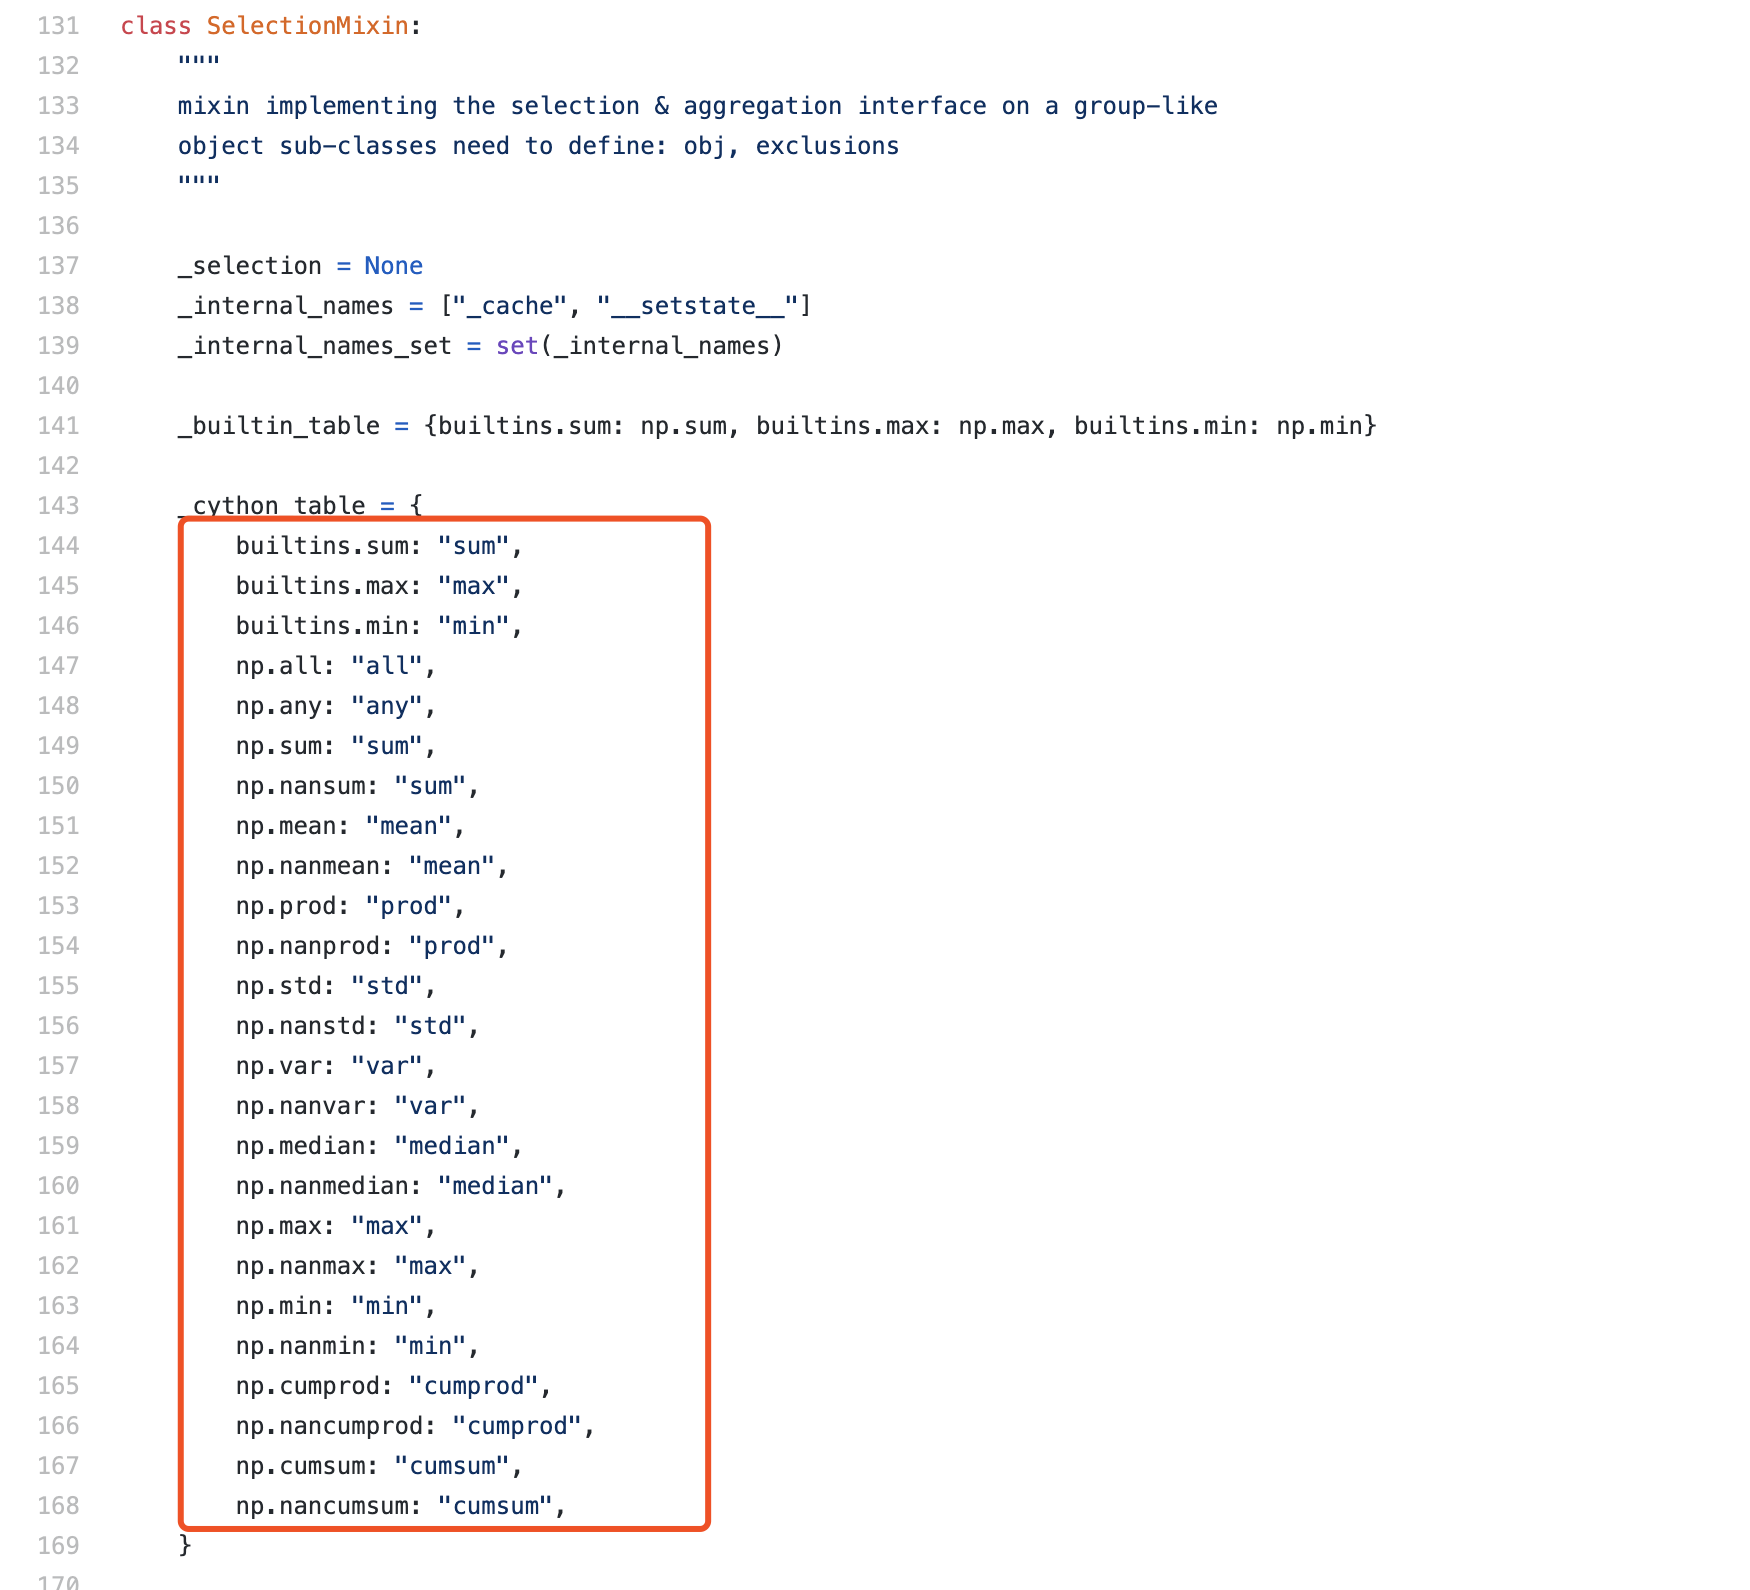

## 2.2 返回不含行索引的聚合数据

In [41]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


# 3. 应用(`apply`)：通用拆分-应用-联合

`GroupBy.apply`将数据分组处理和自定义函数紧密结合，将数据分组后的数据块当做一个整体进行处理。

In [45]:
tips

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...
239,29.03,5.92,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,No,Sat,Dinner,2,0.098204


In [46]:
# 选取小费百分比最高的五组
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [48]:
for name, df in tips.groupby('smoker'):
    print(name)
    print(top(df))

No
     total_bill   tip smoker   day    time  size   tip_pct
88        24.71  5.85     No  Thur   Lunch     2  0.236746
185       20.69  5.00     No   Sun  Dinner     5  0.241663
51        10.29  2.60     No   Sun  Dinner     2  0.252672
149        7.51  2.00     No  Thur   Lunch     2  0.266312
232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes
     total_bill   tip smoker  day    time  size   tip_pct
109       14.31  4.00    Yes  Sat  Dinner     2  0.279525
183       23.17  6.50    Yes  Sun  Dinner     4  0.280535
67         3.07  1.00    Yes  Sat  Dinner     1  0.325733
178        9.60  4.00    Yes  Sun  Dinner     2  0.416667
172        7.25  5.15    Yes  Sun  Dinner     2  0.710345


In [51]:
smoker_tips = tips.groupby('smoker').apply(top)
smoker_tips.loc['No', :]

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990


In [53]:
for name, df in tips.groupby(['smoker', 'day']):
    print(name)
    print(top(df, n=1, column='total_bill'))

('No', 'Fri')
    total_bill   tip smoker  day    time  size   tip_pct
94       22.75  3.25     No  Fri  Dinner     2  0.142857
('No', 'Sat')
     total_bill  tip smoker  day    time  size  tip_pct
212       48.33  9.0     No  Sat  Dinner     4  0.18622
('No', 'Sun')
     total_bill  tip smoker  day    time  size   tip_pct
156       48.17  5.0     No  Sun  Dinner     6  0.103799
('No', 'Thur')
     total_bill  tip smoker   day   time  size   tip_pct
142       41.19  5.0     No  Thur  Lunch     5  0.121389
('Yes', 'Fri')
    total_bill   tip smoker  day    time  size  tip_pct
95       40.17  4.73    Yes  Fri  Dinner     4  0.11775
('Yes', 'Sat')
     total_bill   tip smoker  day    time  size   tip_pct
170       50.81  10.0    Yes  Sat  Dinner     3  0.196812
('Yes', 'Sun')
     total_bill  tip smoker  day    time  size   tip_pct
182       45.35  3.5    Yes  Sun  Dinner     3  0.077178
('Yes', 'Thur')
     total_bill  tip smoker   day   time  size   tip_pct
197       43.11  5.0    Yes  

In [52]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

In [53]:
result = tips.groupby('smoker')['tip_pct'].describe()
result
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

In [54]:
tips.groupby('smoker')['tip_pct']

In [55]:
for name, ser in tips.groupby('smoker')['tip_pct']:
    print(name)
    print(ser.describe())

No
count    151.000000
mean       0.159328
std        0.039910
min        0.056797
25%        0.136906
50%        0.155625
75%        0.185014
max        0.291990
Name: tip_pct, dtype: float64
Yes
count    93.000000
mean      0.163196
std       0.085119
min       0.035638
25%       0.106771
50%       0.153846
75%       0.195059
max       0.710345
Name: tip_pct, dtype: float64


In [56]:
# 等价于
f = lambda x: x.describe()
tips.groupby('smoker')['tip_pct'].apply(f)

smoker       
No      count    151.000000
        mean       0.159328
        std        0.039910
        min        0.056797
        25%        0.136906
        50%        0.155625
        75%        0.185014
        max        0.291990
Yes     count     93.000000
        mean       0.163196
        std        0.085119
        min        0.035638
        25%        0.106771
        50%        0.153846
        75%        0.195059
        max        0.710345
Name: tip_pct, dtype: float64

In [58]:
# tips.groupby('smoker')
x = tips.loc[tips['smoker']=='No', ]
print(x)

     total_bill   tip smoker   day    time  size   tip_pct
0         16.99  1.01     No   Sun  Dinner     2  0.059447
1         10.34  1.66     No   Sun  Dinner     3  0.160542
2         21.01  3.50     No   Sun  Dinner     3  0.166587
3         23.68  3.31     No   Sun  Dinner     2  0.139780
4         24.59  3.61     No   Sun  Dinner     4  0.146808
..          ...   ...    ...   ...     ...   ...       ...
235       10.07  1.25     No   Sat  Dinner     2  0.124131
238       35.83  4.67     No   Sat  Dinner     3  0.130338
239       29.03  5.92     No   Sat  Dinner     3  0.203927
242       17.82  1.75     No   Sat  Dinner     2  0.098204
243       18.78  3.00     No  Thur  Dinner     2  0.159744

[151 rows x 7 columns]


## 3.1 压缩分组键

In [78]:
tips.groupby(['smoker', 'day'], group_keys=False).apply(top, n=1, column='total_bill')

,total_bill,tip,smoker,day,time,size,tip_pct,consume_class
94,22.75,3.25,No,Fri,Dinner,2,0.142857,土豪客户
212,48.33,9.00,No,Sat,Dinner,4,0.186220,土豪客户
156,48.17,5.00,No,Sun,Dinner,6,0.103799,土豪客户
142,41.19,5.00,No,Thur,Lunch,5,0.121389,土豪客户
95,40.17,4.73,Yes,Fri,Dinner,4,0.117750,土豪客户
170,50.81,10.00,Yes,Sat,Dinner,3,0.196812,土豪客户
182,45.35,3.50,Yes,Sun,Dinner,3,0.077178,慷慨客户
197,43.11,5.00,Yes,Thur,Lunch,4,0.115982,土豪客户


## 3.2 分位数与桶分析

In [81]:
tips

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...
239,29.03,5.92,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,No,Sat,Dinner,2,0.098204


In [82]:
pd.cut(tips['tip_pct'], 
                               bins=bins)

0      (0.05, 0.1]
1       (0.1, 0.2]
2       (0.1, 0.2]
3       (0.1, 0.2]
4       (0.1, 0.2]
          ...     
239     (0.2, 1.0]
240    (0.05, 0.1]
241    (0.05, 0.1]
242    (0.05, 0.1]
243     (0.1, 0.2]
Name: tip_pct, Length: 244, dtype: category
Categories (4, interval[float64]): [(0.0, 0.05] < (0.05, 0.1] < (0.1, 0.2] < (0.2, 1.0]]

In [83]:
bins = [0, 0.05, 0.1, 0.2, 1]
tips['consume_class'] = pd.cut(tips['tip_pct'], 
                               bins=bins)  # 分箱
tips

,total_bill,tip,smoker,day,time,size,tip_pct,consume_class
0,16.99,1.01,No,Sun,Dinner,2,0.059447,"(0.05, 0.1]"
1,10.34,1.66,No,Sun,Dinner,3,0.160542,"(0.1, 0.2]"
2,21.01,3.50,No,Sun,Dinner,3,0.166587,"(0.1, 0.2]"
3,23.68,3.31,No,Sun,Dinner,2,0.139780,"(0.1, 0.2]"
4,24.59,3.61,No,Sun,Dinner,4,0.146808,"(0.1, 0.2]"
...,...,...,...,...,...,...,...,...
239,29.03,5.92,No,Sat,Dinner,3,0.203927,"(0.2, 1.0]"
240,27.18,2.00,Yes,Sat,Dinner,2,0.073584,"(0.05, 0.1]"
241,22.67,2.00,Yes,Sat,Dinner,2,0.088222,"(0.05, 0.1]"
242,17.82,1.75,No,Sat,Dinner,2,0.098204,"(0.05, 0.1]"


In [84]:
# 返回的categorical对象可以直接传递给groupby
tips['consume_class']

0      (0.05, 0.1]
1       (0.1, 0.2]
2       (0.1, 0.2]
3       (0.1, 0.2]
4       (0.1, 0.2]
          ...     
239     (0.2, 1.0]
240    (0.05, 0.1]
241    (0.05, 0.1]
242    (0.05, 0.1]
243     (0.1, 0.2]
Name: consume_class, Length: 244, dtype: category
Categories (4, interval[float64]): [(0.0, 0.05] < (0.05, 0.1] < (0.1, 0.2] < (0.2, 1.0]]

In [85]:
def get_stats(df, col=['smoker', 'day', 'time', 'size']):
    return df[col].describe(include='all')
grouped = tips.groupby('consume_class')
grouped.apply(get_stats)

smoker  day    time  size
consume_class                                 
(0.0, 0.05]   count       1    1       1   1.0
              unique      1    1       1   NaN
              top       Yes  Sat  Dinner   NaN
              freq        1    1       1   NaN
              mean      NaN  NaN     NaN   2.0
...                     ...  ...     ...   ...
(0.2, 1.0]    min       NaN  NaN     NaN   1.0
              25%       NaN  NaN     NaN   2.0
              50%       NaN  NaN     NaN   2.0
              75%       NaN  NaN     NaN   2.0
              max       NaN  NaN     NaN   5.0

[44 rows x 4 columns]

In [86]:
label_name = ['普通客户', '慷慨客户', '土豪客户', '大腿客户']
tips['consume_class'] = pd.cut(tips['tip_pct'], 
                               bins=bins,  # 分箱
                               labels=label_name)  # 分箱标签
tips.groupby('consume_class').apply(get_stats)

smoker  day    time  size
consume_class                                 
普通客户          count       1    1       1   1.0
              unique      1    1       1   NaN
              top       Yes  Sat  Dinner   NaN
              freq        1    1       1   NaN
              mean      NaN  NaN     NaN   2.0
...                     ...  ...     ...   ...
大腿客户          min       NaN  NaN     NaN   1.0
              25%       NaN  NaN     NaN   2.0
              50%       NaN  NaN     NaN   2.0
              75%       NaN  NaN     NaN   2.0
              max       NaN  NaN     NaN   5.0

[44 rows x 4 columns]

In [87]:
tips['consume_class']

0      慷慨客户
1      土豪客户
2      土豪客户
3      土豪客户
4      土豪客户
       ... 
239    大腿客户
240    慷慨客户
241    慷慨客户
242    慷慨客户
243    土豪客户
Name: consume_class, Length: 244, dtype: category
Categories (4, object): [普通客户 < 慷慨客户 < 土豪客户 < 大腿客户]

# 4. 数据透视表与交叉表
数据透视表是电子表格程序和其他数据分析软件中常见的数据汇总工具。
它根据一个或多个键聚合成一张表的数据，将数据在矩形格式中排列，其中一些分组键是沿着行的，另一些是沿着列的

In [89]:
# tips.groupby(['day', 'smoker']).mean()
tips.pivot_table(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

In [69]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

In [91]:
tips.groupby(['time', 'day', 'smoker'])['tip_pct', 'size'].mean().unstack(level='smoker')

/Users/mengyuanxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


tip_pct                size          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   0.139622  0.165347  2.000000  2.222222
       Sat   0.158048  0.147906  2.555556  2.476190
       Sun   0.160113  0.187250  2.929825  2.578947
       Thur  0.159744       NaN  2.000000       NaN
Lunch  Fri   0.187735  0.188937  3.000000  1.833333
       Thur  0.160311  0.163863  2.500000  2.352941

In [70]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker', margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [94]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day',
                 aggfunc=sum, margins=True)  # 包含部分总计

day                 Fri        Sat        Sun      Thur        All
time   smoker                                                     
Dinner No      0.418867   7.112145   9.126438  0.159744  16.817194
       Yes     1.488126   6.212055   3.557756       NaN  11.257937
Lunch  No      0.187735        NaN        NaN  7.053669   7.241404
       Yes     1.133620        NaN        NaN  2.785676   3.919295
All            3.228348  13.324199  12.684194  9.999089  39.235830

In [95]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'],
                 columns='day', aggfunc='mean', fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
...                      ...       ...       ...       ...
Lunch  3    Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

[21 rows x 4 columns]

In [96]:
tips.pivot_table?

## 4.1 交叉表：`crosstab`
交叉表是数据透视表的一个特殊情况，计算的是分组中的频率。

In [97]:
from io import StringIO
data = """\
Sample  Nationality  Handedness
1   USA  Right-handed
2   Japan    Left-handed
3   USA  Right-handed
4   Japan    Right-handed
5   Japan    Left-handed
6   Japan    Right-handed
7   USA  Right-handed
8   USA  Left-handed
9   Japan    Right-handed
10  USA  Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')
data

,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


In [98]:
pd.crosstab(data['Nationality'], data['Handedness'], margins=True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


In [99]:
pd.crosstab([tips['time'], tips['day']], tips['smoker'], margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244